In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt


In [2]:
# load data file (already in BERT unified data format)

# data_in = ert.load('data_unified/CER2017-08-24_u_i.txt') 
data_in = ert.load('data_unified/craterlake_2019_feb6.txt') 
# data_in = ert.load('data_unified/fieldschool_wen3_2013_aug26.txt') # no permafrost. bad electrode to test filtering
# data_in = ert.load('data_unified/oldcrow_wen13_2013_oct14.txt') 
# data_in = ert.load('data_unified/oldcrow_wen1_2013_oct13.txt') 
# data_in = ert.load('data_unified/SCH2018-08-29_u_i.txt') 
# data_in = ert.load('data_unified/Teller_ERTB_2019-10-03_0600.ohm') # data from the seward peninsula


print(data_in)

Data: Sensors: 20 data: 57, nonzero entries: ['a', 'b', 'err', 'i', 'm', 'n', 'r', 'u', 'valid']


In [3]:
# calculate geometric factor and apparent resistivity if not already in data file

if max(data_in['k'])==0:
    data_in['k'] = ert.createGeometricFactors(data_in,numerical=True) # include topo in k calculation
    
if max(data_in['rhoa'])==0: 
    if max(data_in['r'])==0: 
        data_in['rhoa'] = (data_in['u']/data_in['i'])*data_in['k'] 
    else:
        data_in['rhoa'] = data_in['r']*data_in['k']


10/08/21 - 16:50:30 - pyGIMLi - INFO - Cache /Users/teddiherringnew/anaconda/envs/idgsp/lib/python3.8/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.8s x 5): /Users/teddiherringnew/Library/Caches/pygimli/15708796426450666959


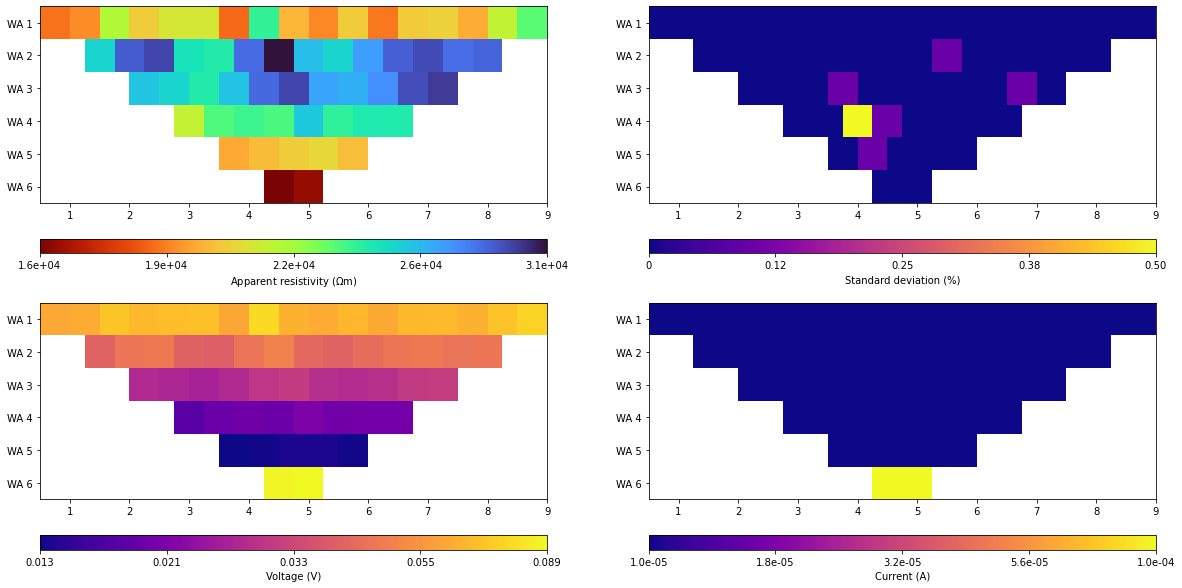

In [4]:
# plot raw data 

mgr = ert.ERTManager(data_in)

fig, ax = plt.subplots(2,2,figsize=[20,10])

mgr.showData(data_in, vals=data_in['rhoa'],ax=ax[0,0],label=r'Apparent resistivity ($\Omega$m)',cMap='turbo_r');

if max(data_in['err']>0):
    mgr.showData(data_in, vals=data_in['err'],ax=ax[0,1],label='Standard deviation (%)',cMap='plasma');
else:
    ax[0,1].text(0.35,0.5,'no err data available',fontsize=16)
    
if max(data_in['u']>0):    
    mgr.showData(data_in, vals=data_in['u'],ax=ax[1,0],label='Voltage (V)',cMap='plasma');
else:
    ax[1,0].text(0.35,0.5,'no voltage data available',fontsize=16)
    
if max(data_in['i']>0):
    mgr.showData(data_in, vals=data_in['i'],ax=ax[1,1],label='Current (A)',cMap='plasma');
else:
    ax[1,1].text(0.35,0.5,'no current data available',fontsize=16)

In [5]:
# to apply a moving median filter we will need to sort our data by depth level and array midpoint. 


# 1. put data into DataFrame (although there is probably a better way to do this)

df = pd.DataFrame(np.array(data_in.dataMap()).T)
header = df.iloc[0]
df = df[1:] 
df.columns = header
df = df.apply(pd.Series.explode).reset_index()



# 2. find midpoint of array

mp = []
for i in range(len(data_in['a'])):
    mp.append(np.mean([
    data_in.sensors()[data_in['a']][i][0],
    data_in.sensors()[data_in['b']][i][0],
    data_in.sensors()[data_in['m']][i][0],
    data_in.sensors()[data_in['n']][i][0],
]))
    
mp = np.array(mp)


# 3. sort by depth level and midpoint so we can apply moving median filter
# note: this works for 2D lines with topography

# to find unique depth levels, check to find unique relative positions of electrodes
ab = df['a'] - df['b']
am = df['a'] - df['m']
an = df['a'] - df['n']

a = (np.array([ab,am,an]).T).astype(dtype=float)

a_uniq = np.unique(a, axis=0)

# sort by depth level
sort_index = np.argsort(a)
i_all = np.linspace(0,len(a),len(a)+1).astype('int')
sort_index = np.array([])

# sort by midpoint
for i in range(len(a_uniq)):
    j = np.where((a==a_uniq[i]).all(axis=1))
    si = np.argsort(mp[j])
    sort_index = np.append(sort_index,i_all[j][si]) 

sort_index = sort_index.astype('int')
data_sort = pd.DataFrame(df,index=sort_index)


/var/folders/5z/g4c125y952l233l_4lb9yt6c0000gp/T/ipykernel_35868/796284992.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df = pd.DataFrame(np.array(data_in.dataMap()).T)


In [6]:
# this is the part where we filter the data

data_filt = data_sort.copy()



# step 1. technical filter

I = (np.unique(np.hstack([ 
    np.where(data_filt['rhoa'] < 0)[0],
    np.where(data_filt['err'] > 10)[0],
    np.where(data_filt['rhoa'] > 9*np.std(data_filt['rhoa']))[0]
])))

data_filt = data_filt.drop(I)
a = np.delete(a,I,0)
n_tf = len(I)



# step 2. moving median filter

th = 0.7 # threshold for filter TODO: make this higher for shallower data
n_mmf = 0 # keeping track of how many data are removed

ikeep = np.ones(data_filt.shape[0],dtype=bool)


for j in range(len(a_uniq)): # loop through each unique depth level
    
    I = np.unique(np.where(a==a_uniq[j])[0])
    
    # moving median of data points
    
    mm = [] 
    r = np.array(data_filt['rhoa'],dtype=np.float)[I]
   
    for i in range(len(I)): # loop through depth level from left to right
        if i==0:
            mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
        elif i==1:
            mm.append(np.median(r[i-1:4])) 
        elif i==len(r)-2:
            mm.append(np.median(r[i-2:])) 
        elif i==len(r)-1:
            mm.append(np.median(r[i-2:])) 
        else:
            mm.append(np.median(r[i-2:i+3])) 
    
    ithrow = np.where(abs(r-mm)/mm > th)[0]
    n_mmf = n_mmf + len(ithrow)
    
    for i in range(len(ithrow)):
        ikeep[I[ithrow[i]]] = 0

print('data points removed by technical filter = %.0f'%n_tf)
print('data points removed by moving median filter = %.0f'%n_mmf)

data_filt = data_filt[ikeep]

data points removed by technical filter = 0
data points removed by moving median filter = 0


In [7]:
# put everything back into the data container

data_out = pg.DataContainerERT()

# sensors are the same
for i in range(0,len(data_in.sensors())):
    data_out.createSensor(np.array(data_in.sensors()[i])) # 2D, no topography

# add filtered quadripoles and data 
cols = data_filt.columns
for i in range(len(cols)):
    if max(data_filt[cols[i]]) > 0:
        data_out[cols[i]] = np.array(data_filt[cols[i]])

0 data points removed (0.0% of the data)


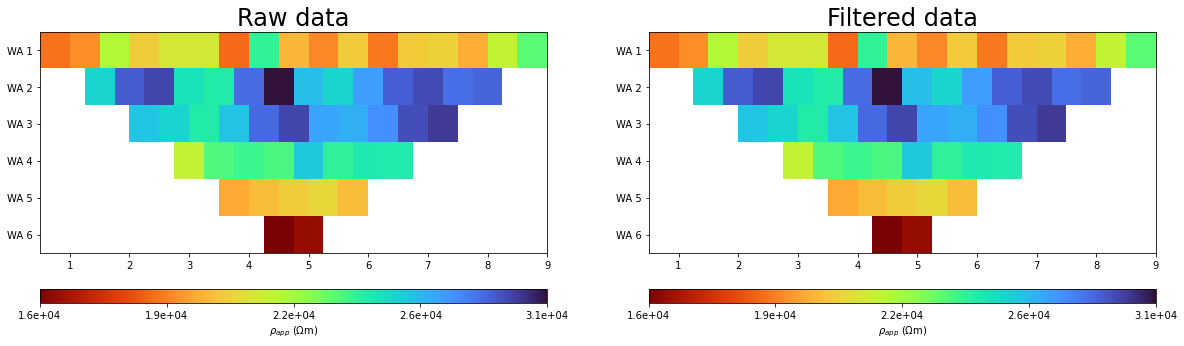

In [8]:
# plot filtered data

fig, ax = plt.subplots(1,2,figsize=[20,5])

mgr.showData(data_in, vals=data_in['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
ax[0].set_title('Raw data',fontsize=24);

mgr.showData(data_out, vals=data_out['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
ax[1].set_title('Filtered data',fontsize=24);

print('%.0f data points removed (%.1f%% of the data)'%(n_tf+n_mmf, float((data_in.size()-data_out.size())/data_in.size()*100)))

In [9]:
# first pass inversion

# assume simple noise model for now
# TODO: incorporate measurement errors if known

data_out['err'] = ert.estimateError(
    data_out, 
#     absoluteUError=0.00005, # 50µV
#     relativeError=0.03 # 3% noise
)  

# set wether lambda is being optimized by L-curve

mgr.inv.inv.setOptimizeLambda(True)


# run inversion

mod = mgr.invert(
    data_out,
    blockymodel=True, 
    verbose=True, 
#     robustdata=True, # can use robust data constraint 
#     lam = 20, # can change regularization parameter
#     paraMaxCellSize=10, # can change the maximum cell area
#     zWeight=0.3 # can change the ratio of smoothness_z / smoothness_x
)

# getting lambda, chi2, rms error

lam = mgr.inv.inv.getLambda()
chi2 = mgr.inv.inv.getChi2()
rms = np.sqrt(np.mean(((data_out['rhoa']-mgr.inv.response)/data_out['rhoa'])**2))*100

10/08/21 - 16:50:32 - pyGIMLi - INFO - Found 2 regions.
10/08/21 - 16:50:32 - pyGIMLi - INFO - Region with smallest marker (1) set to background
10/08/21 - 16:50:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/08/21 - 16:50:32 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
10/08/21 - 16:50:32 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
10/08/21 - 16:50:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/08/21 - 16:50:32 - pyGIMLi - INFO - Starting inversion.
10/08/21 - 16:50:32 - pyGIMLi - INFO - Set default startmodel to median(data values)=24288.281127712817
10/08/21 - 16:50:32 - pyGIMLi - INFO - Created startmodel from forward operator: 295 [24288.281127712817,...,24288.281127712817]


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  0

Statistics:

  Input vertices: 47
  Input segments: 48
  Input holes: 0

  Mesh vertices: 260
  Mesh triangles: 449
  Mesh edges: 708
  Mesh exterior boundary edges: 69
  Mesh interior boundary edges: 15
  Mesh subsegments (constrained edges): 84

min/max(dweight) = 33.3333/33.3333
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x164aadc70>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x16473a8b0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x164aadd10>
min/max (data): 1.6e+04/3.1e+04
m

Text(0.5, 1.0, 'Predicted data')

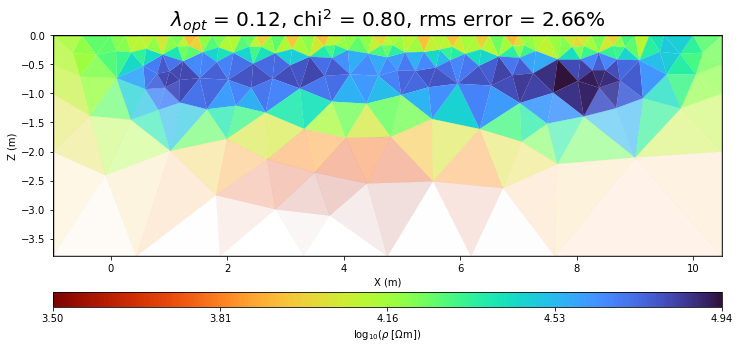

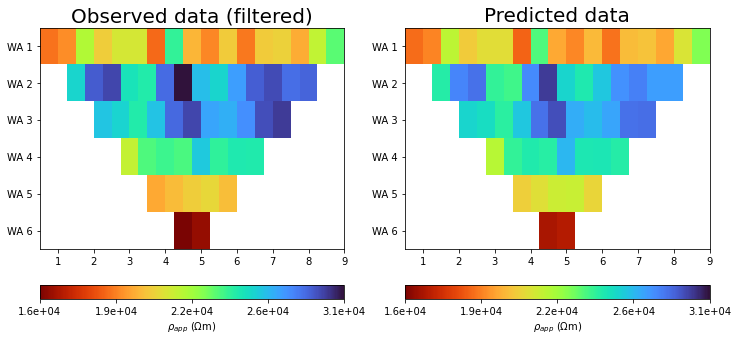

In [10]:
# plot results

fig, ax = plt.subplots(1,1,figsize=[12,5])

ax, cBar = mgr.showResult(
    np.log10(mod),
    ax=ax,
    cMap='turbo_r',
    coverage=mgr.coverage()

);

cBar.set_label(r'log$_{10}$($\rho$ [$\Omega$m])')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.set_title(r'$\lambda_{opt}$ = %.2f, chi$^2$ = %.2f, rms error = %.2f%%'%(lam,chi2,rms),fontsize=20);


fig, ax = plt.subplots(1,2,figsize=[12,5])
mgr.showData(data_out, vals=data_out['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
mgr.showData(data_out, vals=mgr.inv.response,ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r',cMin=min(data_out['rhoa']),cMax=max(data_out['rhoa']));
ax[0].set_title('Observed data (filtered)',fontsize=20)
ax[1].set_title('Predicted data',fontsize=20)